### Visión por Computadora I


Jorge Ceferino Valdez

Trabajo Práctico N° 2

- Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
    1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.
    2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
    3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
# mostrar version de python
print("Version de python: ", sys.version)
# mostrar version de opencv
print("Version de opencv: ", cv2.__version__)

# Version de python:  3.9.18 (main, Sep 11 2023, 13:41:44) 
# [GCC 11.2.0]
# Version de opencv:  4.8.1

Version de python:  3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
Version de opencv:  4.8.1


___


### Punto 1


#### Implementación de create_gauss_filter

In [3]:
# Filtrado por Fourier en el dominio de la frecuencia
# Usando la libreria de numpy
def create_gauss_filter(h, w, k_size, sigma):
    y, x = np.meshgrid(np.arange(h) - h // 2, np.arange(w) - w // 2, indexing='ij')
    kernel = np.exp(-(x**2 + y**2) / (2. * sigma**2))
    kernel /= kernel.sum()  # Normalizar para que la suma sea 1

    # Zero-padding para obtener el tamaño deseado del kernel
    padded_kernel = np.zeros((h, w))
    padded_kernel[:kernel.shape[0], :kernel.shape[1]] = kernel

    # Calcular la transformada de Fourier del kernel
    fft_kernel = np.fft.fftshift(np.fft.fft2(padded_kernel))

    return padded_kernel, fft_kernel

def apply_filter(image, fft_kernel):
    # Convertir la imagen a escala de grises si es a color
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calcular la transformada de Fourier de la imagen
    fft_image = np.fft.fftshift(np.fft.fft2(image))

    # Aplicar el filtro en el dominio de la frecuencia
    filtered_fft_image = fft_image * fft_kernel

    # Obtener la imagen filtrada en el dominio espacial
    filtered_image = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft_image)))

    return filtered_image.astype(np.uint8)

In [4]:
def calcular_nitidez_frecuencia(input_image):
    # Calcular los coeficientes de Fourier de la imagen
    fourier_coefficients = np.fft.fftshift(np.fft.fft2(input_image)) 

    # Calcular el valor absoluto de todos los coeficientes de Fourier
    abs_values = np.abs(fourier_coefficients)

    # Calcular el valor máximo entre todos los coeficientes
    maximum_value = np.max(abs_values)

    # Calcular el número total de coeficientes que son mayores que
    # el valor máximo / 1000
    total = abs_values[abs_values > maximum_value / 1000].size

    # Calcular la calidad de la imagen como el número total de coeficientes 
    # dividido por el tamaño de la imagen
    result = total / input_image.size

    return result

In [5]:
# Tomare el operador A.13. Squared gradient (GRA4). 
# Equivalente a la energía del gradiente de la imagen
def calcular_nitidez_grae(image):
    # Convertir la imagen a escala de grises
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calcular el gradiente en las direcciones x e y utilizando Sobel
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calcular la magnitud del gradiente
    magnitud_gradiente = np.sqrt(np.square(grad_x) + np.square(grad_y))
    
    # Elevar al cuadrado la magnitud del gradiente para obtener la energía del gradiente de la imagen (GRAE)
    GRAE = np.square(magnitud_gradiente)
    
    # Calcular la nitidez promedio de la imagen
    nitidez = np.mean(GRAE)
    
    return nitidez

In [6]:
# Parámetros de ejemplo

# Cargar imagen
#image = cv2.imread('../data/fft_alfa_pred.png', cv2.IMREAD_GRAYSCALE)
#image = cv2.imread('../data/enterprise.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('../data/enterprise.jpeg', cv2.IMREAD_GRAYSCALE)

h, w = image.shape  # Tamaño de la imagen
k_size = 21  # Tamaño del kernel
sigma_values = [0.5, 1, 3, 7, 10]  # Valores de sigma para probar


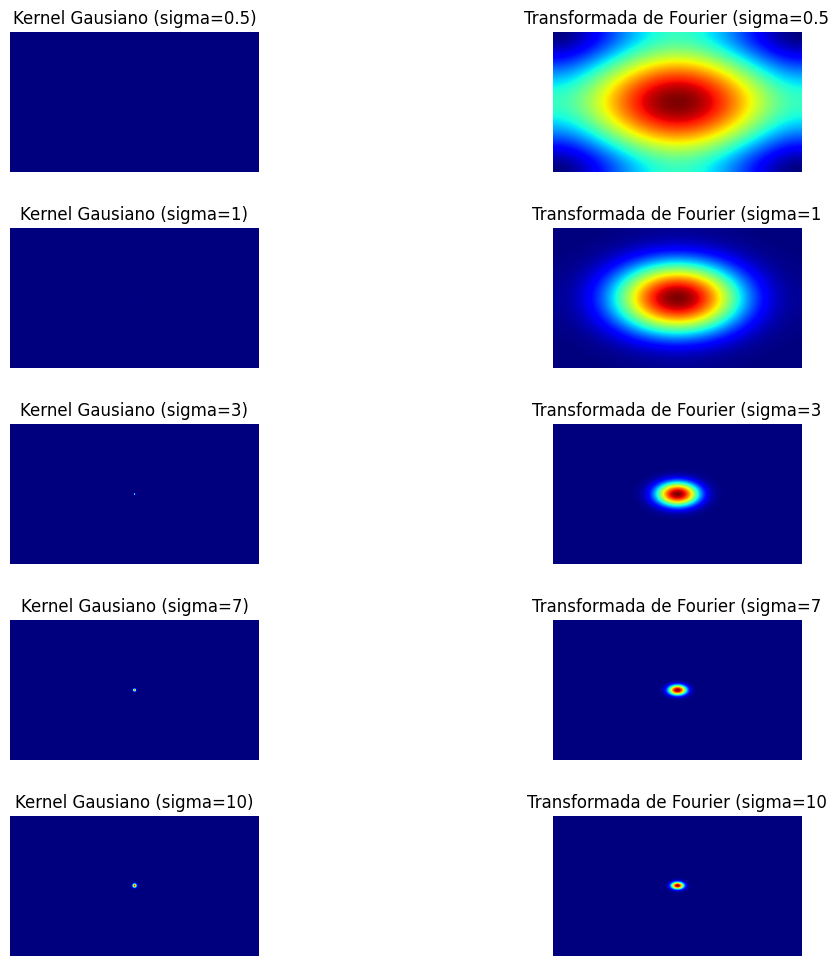

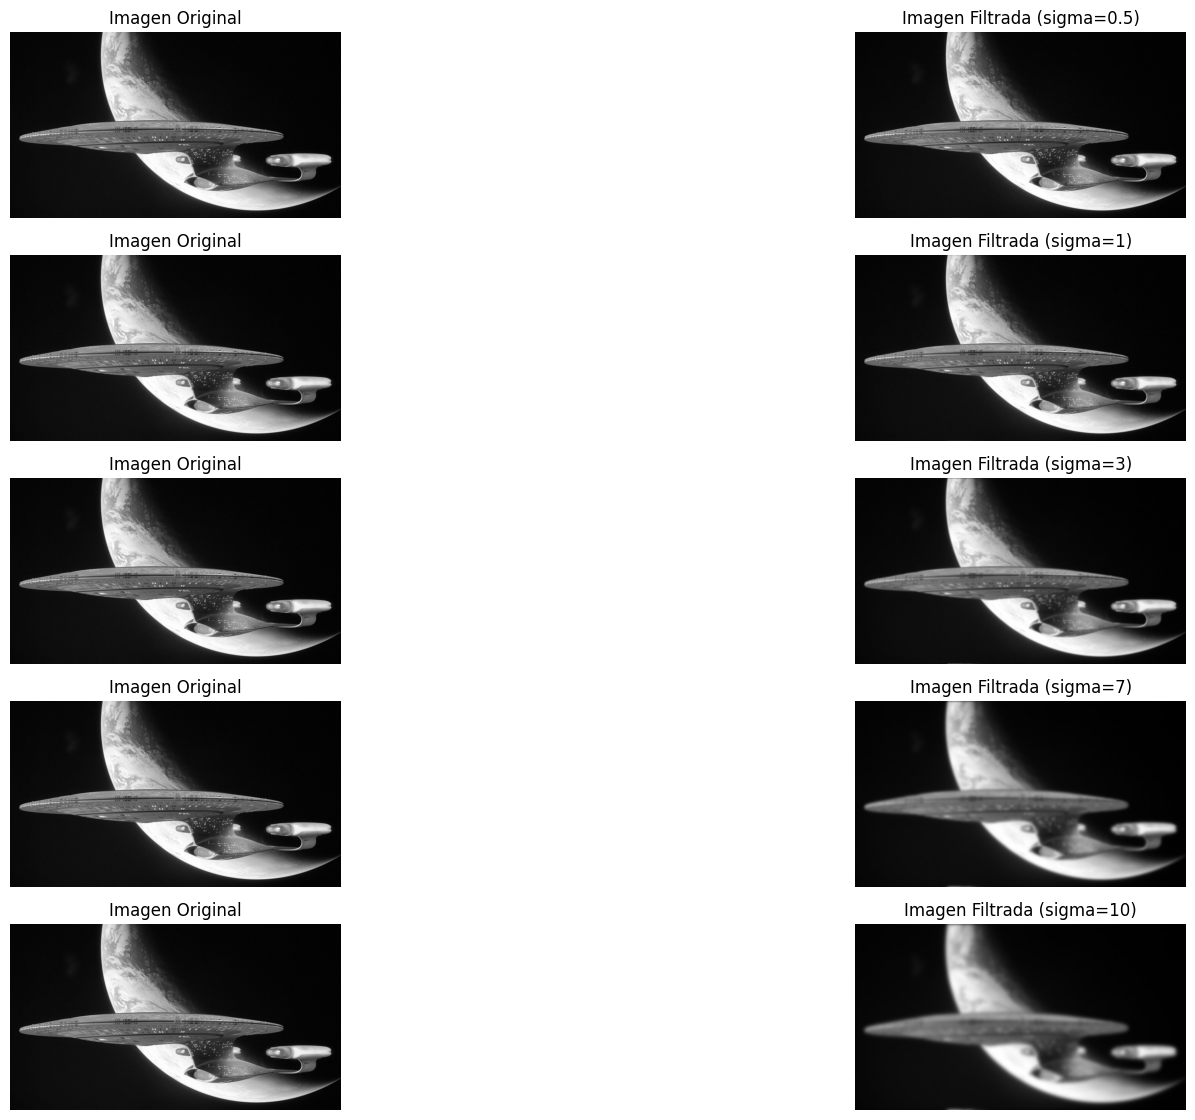

In [7]:
# Crear gráficos para diferentes tamaños de kernel y sigma
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, sigma in enumerate(sigma_values):
    # Crear filtro gaussiano y obtener su transformada de Fourier
    # Usando la implementación con numpy
    padded_kernel, fft_kernel = create_gauss_filter(h, w, k_size, sigma)

    # Graficar filtro gaussiano en el dominio espacial

    #plt.subplot(1,2,1)
    plt.subplot(len(sigma_values), 2, i*2+1)
    plt.axis('off')
    plt.title(f'Kernel Gausiano (sigma={sigma})')
    plt.imshow(padded_kernel, cmap='jet')    

    # Graficar transformada de Fourier del filtro gaussiano
    plt.subplot(len(sigma_values), 2, i*2+2)
    plt.axis('off')
    plt.title(f'Transformada de Fourier (sigma={sigma}')
    plt.imshow(np.log(np.abs(fft_kernel) + 1), cmap='jet')

# Aplicar filtro a la imagen de ejemplo fuera del bucle
plt.figure(figsize=(20, 14))
filtered_images = []

for sigma in sigma_values:
    _, fft_kernel = create_gauss_filter(h, w, k_size, sigma)
    filtered_image = apply_filter(image, fft_kernel)
    filtered_images.append(filtered_image)

# Visualizar la imagen original y la imagen filtrada para cada sigma
for i, sigma in enumerate(sigma_values):
    plt.subplot(len(sigma_values), 2, i*2+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original')
    plt.axis('off')

    filtered_image_shift = np.fft.fftshift(filtered_images[i])
    plt.subplot(len(sigma_values), 2, i*2+2)
    #plt.imshow(filtered_images[i], cmap='gray')
    plt.imshow(filtered_image_shift, cmap='gray')
    plt.title(f'Imagen Filtrada (sigma={sigma})')
    plt.axis('off')

plt.show()

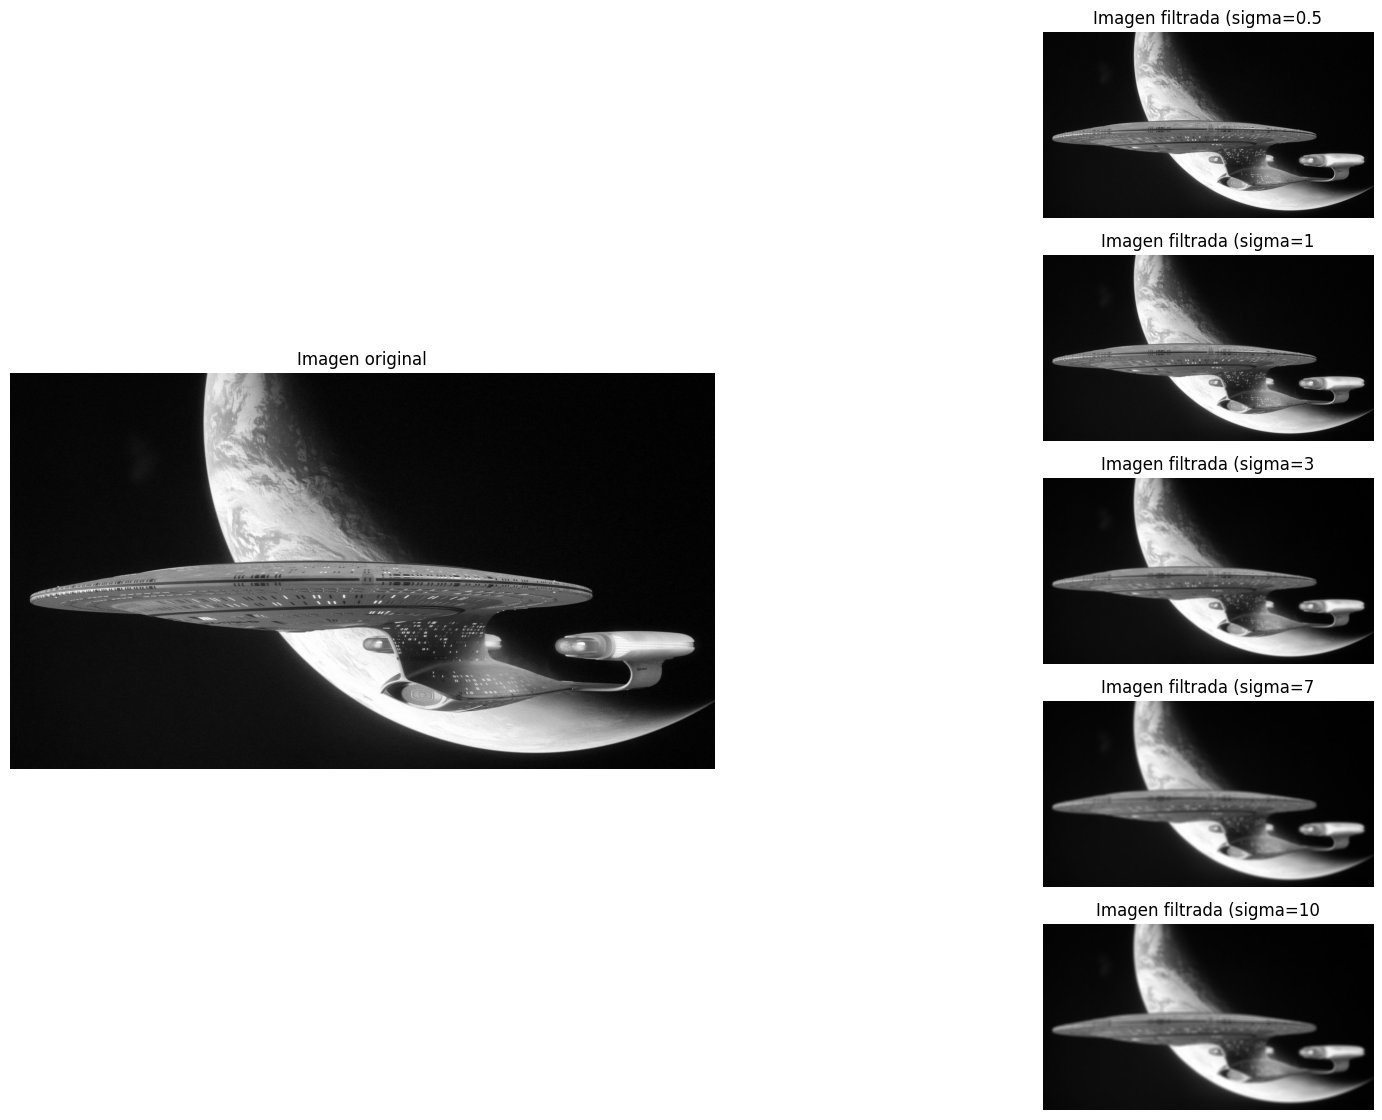

In [8]:
# Filtrado en el dominio espacial
plt.figure(figsize=(20, 14))
#plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, sigma in enumerate(sigma_values):
    # Crear filtro gaussiano y obtener su transformada de Fourier
    # Usando la implementación con numpy
    #padded_kernel, fft_kernel = create_gauss_filter(h, w, k_size, sigma)
    imagen_filtrada = cv2.GaussianBlur(image, (k_size, k_size), sigma)

    # Graficar filtro gaussiano en el dominio espacial

    plt.subplot(1,2,1)
    #plt.subplot(len(sigma_values), 2, i*2+1)
    plt.axis('off')
    plt.title(f'Imagen original')
    plt.imshow(image, cmap='gray')    

    # Graficar transformada de Fourier del filtro gaussiano
    plt.subplot(len(sigma_values), 2, i*2+2)
    plt.axis('off')
    plt.title(f'Imagen filtrada (sigma={sigma}')
    plt.imshow(imagen_filtrada, cmap='gray')

In [9]:
# Cargar imagen
#image = cv2.imread('../data/fft_alfa_pred.png', cv2.IMREAD_GRAYSCALE)
#image = cv2.imread('../data/enterprise.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('../data/jaylah.jpeg', cv2.IMREAD_GRAYSCALE)

h, w = image.shape  # Tamaño de la imagen
k_size = 21  # Tamaño del kernel
sigma_values = [0.5, 1, 3, 7, 10]  # Valores de sigma para probar

# Lista para almacenar los valores de nitidez en el dominio de la frecuencia 
# usando el el método del primer paper
nitidez_frecuencia_list_fou = [] 
# Lista para almacenar los valores de nitidez en el dominio de la frecuencia 
# usando squared gradient (GRAE)
nitidez_grae_list_fou = []

# lista para almacenar los valores de nitidez en el dominio espacial
# usando el el método del primer paper
nitidez_frecuencia_list_spa = []
# Lista para almacenar los valores de nitidez en el dominio espacial
# usando squared gradient (GRAE)
nitidez_grae_list_spa = []

> Aplico filtros a la imagen generando 5 imágenes y luego aplicare las métricas de los papers



<Figure size 1200x1200 with 0 Axes>

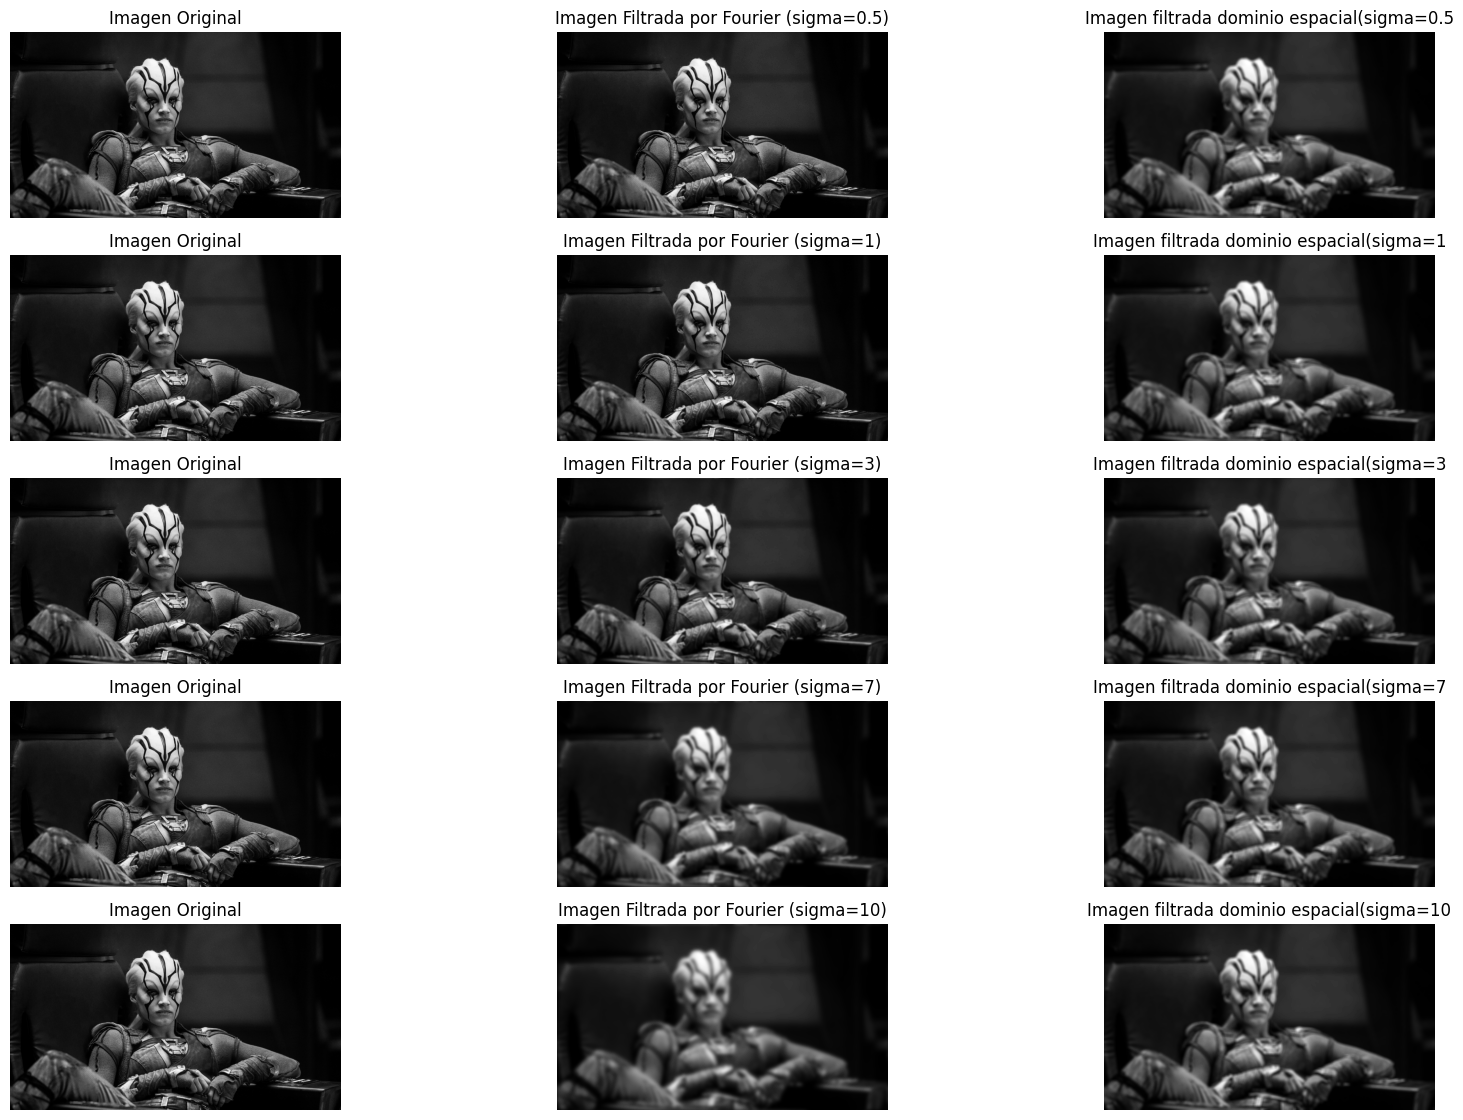

In [10]:
# Crear gráficos para diferentes tamaños de kernel y sigma
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)


# Aplicar filtro a la imagen de ejemplo fuera del bucle
plt.figure(figsize=(20, 14))
filtered_images = []

for sigma in sigma_values:
    _, fft_kernel = create_gauss_filter(h, w, k_size, sigma) # Creo el kernel gaussiano
    filtered_image = apply_filter(image, fft_kernel) # Aplico el filtro a la imagen
    filtered_images.append(filtered_image)
    nitidez_frecuencia_list_fou.append(calcular_nitidez_frecuencia(filtered_image)) # Calculo la nitidez en el dominio de la frecuencia y la guardo en la lista
    nitidez_grae_list_fou.append(calcular_nitidez_grae(filtered_image)) # Calculo la nitidez usando GRAE y la guardo en la lista

    filtered_image_esp = cv2.GaussianBlur(image, (k_size, k_size), sigma) # Aplico el filtro gaussiano en el dominio espacial
    nitidez_frecuencia_list_spa.append(calcular_nitidez_frecuencia(filtered_image_esp)) # Calculo la nitidez en el dominio de la frecuencia y la guardo en la lista
    nitidez_grae_list_spa.append(calcular_nitidez_grae(filtered_image_esp)) # Calculo la nitidez usando GRAE y la guardo en la lista


# Visualizar la imagen original y la imagen filtrada para cada sigma
for i, sigma in enumerate(sigma_values):
    plt.subplot(len(sigma_values), 3, i*3+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original')
    plt.axis('off')

    filtered_image_shift = np.fft.fftshift(filtered_images[i])
    plt.subplot(len(sigma_values), 3, i*3+2)
    #plt.imshow(filtered_images[i], cmap='gray')
    plt.imshow(filtered_image_shift, cmap='gray')
    plt.title(f'Imagen Filtrada por Fourier (sigma={sigma})')
    plt.axis('off')

    # Graficar transformada de Fourier del filtro gaussiano
    plt.subplot(len(sigma_values), 3, i*3+3)
    plt.axis('off')
    plt.title(f'Imagen filtrada dominio espacial(sigma={sigma}')
    plt.imshow(filtered_image_esp, cmap='gray')

plt.show()

In [11]:
# Impresión de los valores de nitidez en el dominio de la frecuencia, 
#usando el método del primer paper y usando GRAE del segundo paper
print('Valores de nitidez en el dominio de la frecuencia:', nitidez_frecuencia_list_fou)
print('Valores de nitidez usando GRAE:', nitidez_grae_list_fou)

Valores de nitidez en el dominio de la frecuencia: [0.016005497685185187, 0.013978105709876544, 0.00769434799382716, 0.003197820216049383, 0.0020008680555555556]
Valores de nitidez usando GRAE: [5120.437363040123, 2644.65339216821, 725.6602334104938, 202.38235243055556, 112.15265142746914]


In [12]:
# Impresión de los valores de nitidez en el dominio espacial, usando
# el método del primer paper y usando GRAE del segundo paper
print('Valores de nitidez en el dominio espacial:', nitidez_frecuencia_list_spa)
print('Valores de nitidez usando GRAE:', nitidez_grae_list_spa)



Valores de nitidez en el dominio espacial: [0.01575665509259259, 0.013819926697530864, 0.007707851080246913, 0.004323398919753086, 0.003911554783950617]
Valores de nitidez usando GRAE: [5103.803058449074, 2622.9258400848767, 720.1334645061728, 301.2852797067901, 265.5713387345679]


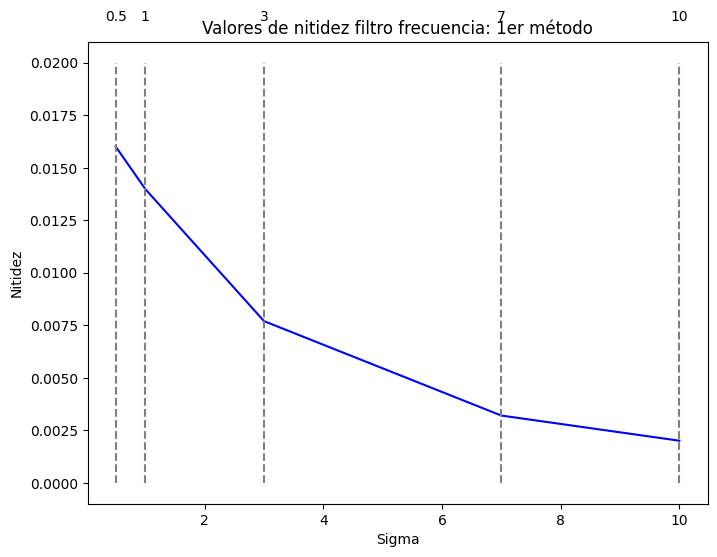

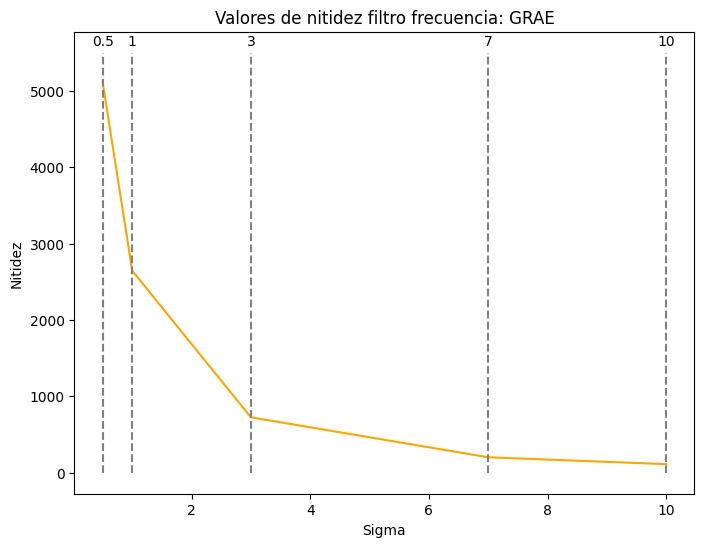

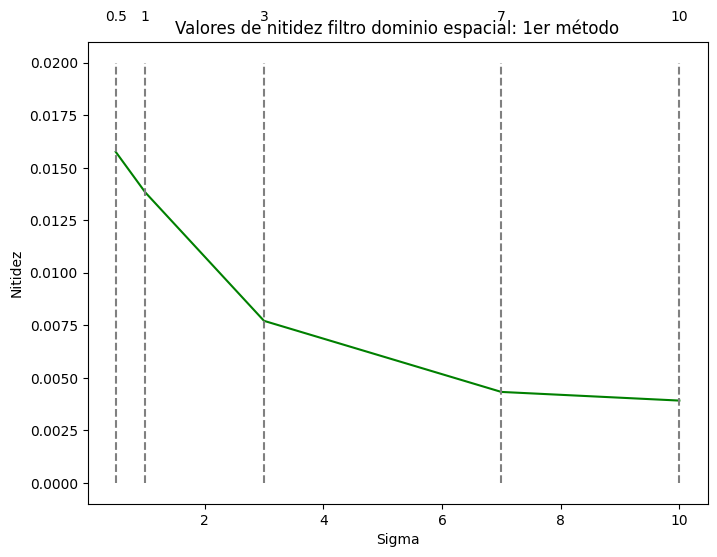

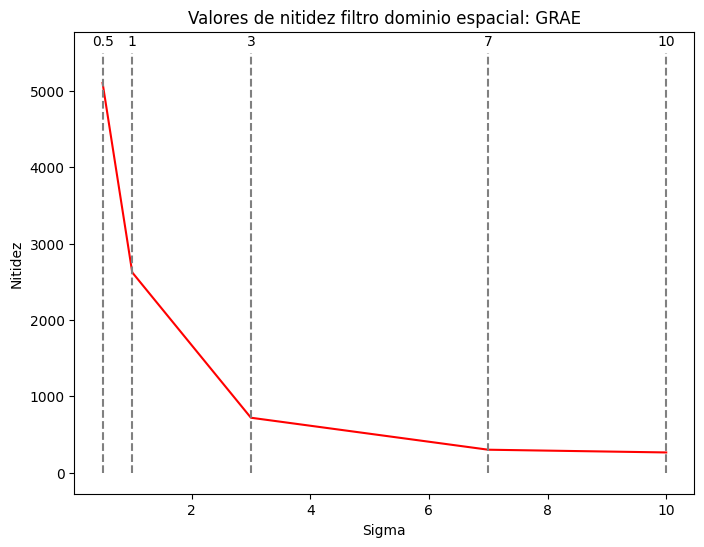

In [13]:
# Graficar Valores de nitidez del filtro Fourier usando 1er método
plt.figure(1, figsize=(8, 6))  # Tamaño de la figura
plt.plot(sigma_values, nitidez_frecuencia_list_fou, color='blue')  # Color azul
plt.xlabel('Sigma')
plt.ylabel('Nitidez')
plt.title('Valores de nitidez filtro frecuencia: 1er método')
for sigma in sigma_values:
    plt.vlines(sigma, 0, 0.02, linestyles='dashed', colors='gray')
    plt.text(sigma, 0.022, str(sigma), ha='center')
plt.show()

# Graficar Valores de nitidez del dominio Fourier usando GRAE
plt.figure(2, figsize=(8, 6))  # Tamaño de la figura
plt.plot(sigma_values, nitidez_grae_list_fou, color='orange')  # Color naranja
plt.xlabel('Sigma')
plt.ylabel('Nitidez')
plt.title('Valores de nitidez filtro frecuencia: GRAE')
for sigma in sigma_values:
    plt.vlines(sigma, 0, 5500, linestyles='dashed', colors='gray')
    plt.text(sigma, 5600, str(sigma), ha='center')
plt.show()

# Graficar Valores de nitidez del filtro dominio espacial usando 1er método
plt.figure(3, figsize=(8, 6))  # Tamaño de la figura
plt.plot(sigma_values, nitidez_frecuencia_list_spa, color='green')  # Color verde
plt.xlabel('Sigma')
plt.ylabel('Nitidez')
plt.title('Valores de nitidez filtro dominio espacial: 1er método')
for sigma in sigma_values:
    plt.vlines(sigma, 0, 0.02, linestyles='dashed', colors='gray')
    plt.text(sigma, 0.022, str(sigma), ha='center')
plt.show()

# Graficar Valores de nitidez del dominio espacial usando GRAE
plt.figure(4, figsize=(8, 6))  # Tamaño de la figura
plt.plot(sigma_values, nitidez_grae_list_spa, color='red')  # Color rojo
plt.xlabel('Sigma')
plt.ylabel('Nitidez')
plt.title('Valores de nitidez filtro dominio espacial: GRAE')
for sigma in sigma_values:
    plt.vlines(sigma, 0, 5500, linestyles='dashed', colors='gray')
    plt.text(sigma, 5600, str(sigma), ha='center')
plt.show()
